<a href="https://colab.research.google.com/github/gopimandala/newdevops/blob/master/timeseries_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [2]:
import os
os.listdir('/content')

['.config',
 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
 'model_experiments',
 'sample_data']

In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
# df.info(), len(df)

In [5]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


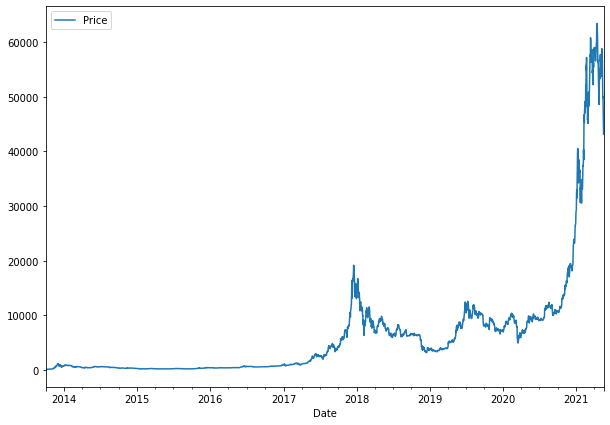

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))

In [7]:
prices = bitcoin_prices['Price'].to_numpy()
timesteps = bitcoin_prices.index.to_numpy()
len(prices), timesteps[0:2]

(2787,
 array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [8]:
trainsize = int(0.8*len(prices))
trainsize

2229

In [9]:
xtrain, xtest = timesteps[:trainsize], timesteps[trainsize:]
ytrain, ytest = prices[:trainsize], prices[trainsize:]

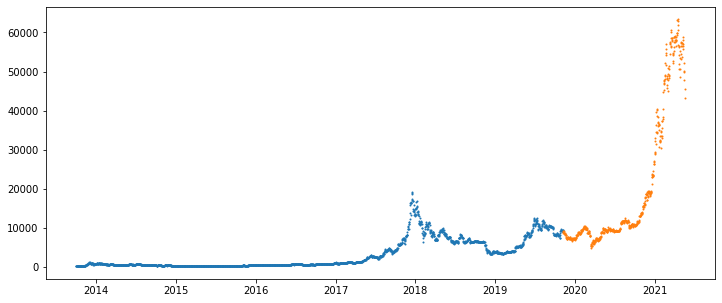

In [10]:
plt.figure(figsize=(12,5))
plt.scatter(xtrain,ytrain,s=1)
plt.scatter(xtest,ytest,s=1)

In [11]:
naivefc = ytest[:-1]
len(naivefc), len(ytest)

(557, 558)

In [12]:
import tensorflow as tf
mae = tf.keras.metrics.mean_absolute_error(ytest[1:],naivefc)
mse = tf.keras.metrics.mean_squared_error(ytest[1:],naivefc)
rmse = tf.sqrt(mse)
mape = tf.keras.metrics.mean_absolute_percentage_error(ytest[1:],naivefc)
mae, mse, rmse, mape

(<tf.Tensor: shape=(), dtype=float64, numpy=567.9802273457541>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1147547.125023896>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1071.2362601330744>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.516524929982267>)

In [13]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(ytest).numpy()

20056.632963737226

In [14]:
import numpy as np
horizon = 1 # predict 1 step at a time
window_size = 3 # use a week worth of timesteps to predict the horizon

In [15]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.
  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [16]:
full_windows, full_labels = make_windows(prices, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

(2784, 2784)

In [17]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} , Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483] , Label: [118.67466]
Window: [125.455   108.58483 118.67466] , Label: [121.33866]
Window: [108.58483 118.67466 121.33866] , Label: [120.65533]


In [18]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [19]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2227, 557, 2227, 557)

In [20]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483],
        [125.455  , 108.58483, 118.67466],
        [108.58483, 118.67466, 121.33866],
        [118.67466, 121.33866, 120.65533],
        [121.33866, 120.65533, 121.795  ]]), array([[118.67466],
        [121.33866],
        [120.65533],
        [121.795  ],
        [123.033  ]]))

In [21]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-horizon-1]), ytrain[window_size:])

False

In [22]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [23]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 3s 130ms/step - loss: 1353.4988 - mae: 1353.4988 - val_loss: 2632.2251 - val_mae: 2632.2251
Epoch 2/100
18/18 [==============================] - 1s 70ms/step - loss: 268.9973 - mae: 268.9973 - val_loss: 874.7808 - val_mae: 874.7808
Epoch 3/100
18/18 [==============================] - 1s 67ms/step - loss: 168.1634 - mae: 168.1634 - val_loss: 869.4909 - val_mae: 869.4909
Epoch 4/100
18/18 [==============================] - 1s 62ms/step - loss: 153.6962 - mae: 153.6962 - val_loss: 810.6486 - val_mae: 810.6486
Epoch 5/100
18/18 [==============================] - 1s 74ms/step - loss: 146.0801 - mae: 146.0801 - val_loss: 807.1738 - val_mae: 807.1738
Epoch 6/100
18/18 [==============================] - 1s 70ms/step - loss: 145.0121 - mae: 145.0121 - val_loss: 793.3164 - val_mae: 793.3164
Epoch 7/100
18/18 [==============================] - 2s 101ms/step - loss: 140.0080 - mae: 140.0080 - val_loss: 775.6751 - val_mae: 775.6751
Epoch 8/100
18

In [24]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 569.7734 - mae: 569.7734


[569.7734375, 569.7734375]

In [25]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 564.8567 - mae: 564.8567


[564.856689453125, 564.856689453125]

In [26]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds), model_1_preds[:10]

(557, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([9258.936, 8846.577, 8790.443, 9078.188, 8783.84 , 8753.273,
        8774.815, 8685.238, 8528.847, 8482.132], dtype=float32)>)

In [27]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  #mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()} #,"mase": mase.numpy()}

In [28]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 564.8567, 'mape': 2.5255516, 'mse': 1147651.1, 'rmse': 1071.2848}

In [29]:
# Create a naïve forecast
naive_forecast = ytest[:-1] # Naïve forecast equals every value excluding the last value

In [30]:
naive_results = evaluate_preds(y_true=ytest[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802, 'mape': 2.5165248, 'mse': 1147547.0, 'rmse': 1071.2362}